Put on hold as lfilter drops the imaginary part of the values which is different to matlab filter

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.signal import butter, freqz, lfilter, spectrogram

In [3]:
# Load in file to pandas dataframe
df = pd.read_table(
    "C:/Users/macka/Google Drive/Level-4-Project/data/raw/Dataset_97.dat",
    sep="\n",
    header=None)

In [4]:
# Switches out i for j to ensure python compatibility
def convert_to_complex(complex_string):
    return complex(complex_string[0].replace('i', 'j'))

In [5]:
# Grab RADAR settings from top of file
center_frequency = float(df.iloc[0])
sweep_time = float(df.iloc[1])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[2])
bandwidth = float(df.iloc[3])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time

In [6]:
# Put data values into an array
data = df.iloc[4:]
data = data.apply(convert_to_complex, axis=1)
data = data.values

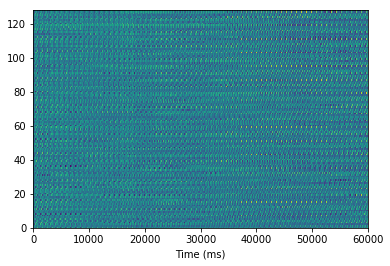

In [7]:
# Reshape into chirps over time
data_time = np.reshape(data, (int(number_of_time_samples), int(number_of_chirps)))
plt.xlabel("Time (ms)")
plt.pcolormesh((np.abs(data_time)))

In [8]:
# Does nothing (copied from original matlab file)
win = np.ones((int(number_of_time_samples), data_time.shape[1]))

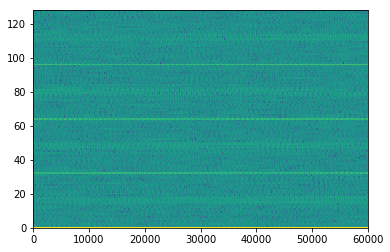

In [9]:
# Apply fast fourier transform
fft_applied = np.fft.fft((data_time * win), axis=0)
plt.pcolormesh(20 * np.log10(np.abs(fft_applied)))

In [10]:
print(fft_applied.shape, fft_applied[0][0], fft_applied[1][0])
# first row is very large in magnitude?

(128, 60000) (261541+263636j) (51.06987116029804-44.32898342745747j)


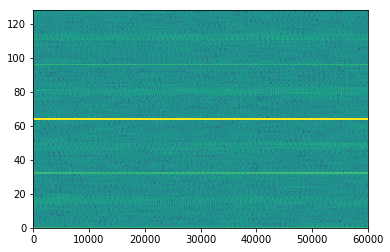

In [11]:
# shift fft
fft_shifted = np.fft.fftshift(fft_applied, axes=(0,))
plt.pcolormesh(20 * np.log10(np.abs(fft_shifted)))

In [13]:
print(fft_shifted.shape, fft_shifted[0][0], fft_shifted[64][0])
# fftshift switches bottom and top halves (64,0) is equal to (0,0) of original fft

(128, 60000) (315-480j) (261541+263636j)


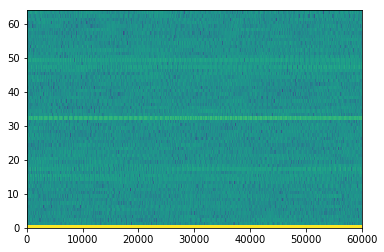

In [12]:
data_range = fft_shifted[int(number_of_time_samples/2):int(number_of_time_samples), :] # take top half
plt.pcolormesh(20 * np.log10(np.abs(data_range)))

In [15]:
print(data_range.shape)
print(data_range[1][0])

(64, 60000)
(51.06987116029804-44.32898342745747j)


In [14]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [16]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1

In [17]:
print(ns)

60000


In [19]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)


In [20]:
data_range_MTI.shape

(64, 60000)

In [21]:
(b, a) = butter(4, 0.01, btype="high") # made a filter remove DC component and very low frequency components

In [22]:
print(b, a)

[ 0.95978223 -3.83912892  5.75869338 -3.83912892  0.95978223] [ 1.         -3.91790787  5.75707638 -3.76034951  0.92118193]


In [23]:
(f1, h) = freqz(b, a, ns)

In [24]:
print(f1, h)

[0.00000000e+00 5.23598776e-05 1.04719755e-04 ... 3.14143557e+00
 3.14148793e+00 3.14154029e+00] [-1.18712144e-10+0.00000000e+00j -4.74844288e-10+2.01816381e-12j
 -7.12246027e-10+6.18486026e-12j ...  1.00000000e+00+3.22408008e-06j
  1.00000000e+00+2.14938672e-06j  1.00000000e+00+1.07469336e-06j]


In [25]:
print(shape)

NameError: name 'shape' is not defined

In [26]:
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)
    print(data_range_MTI[i, :ns])
    break

[ 2.51022404e+05+2.53033148e+05j  2.29972020e+05+2.32677662e+05j
  2.09820560e+05+2.10698352e+05j ... -1.18347101e+03-7.44653480e+01j
 -5.65211363e+01-1.04606562e+03j  6.26696331e+02+9.60371347e+01j]


In [27]:
print(data_range_MTI.shape)
print(data_range_MTI[63][0]) # lost it's complex value
# plt.pcolormesh(20 * np.log10(np.abs(data_range_MTI)))


(64, 60000)
0j


In [106]:
freq = np.arange(0, ns-1)
freq = freq * sampling_frequency/(2*ns)

In [107]:
range_axis = (freq * 3e8*sweep_time)/(2*bandwidth)

In [108]:
data_range_MTI = data_range_MTI[1:, :]
data_range = data_range[1:, :]

In [109]:
print(data_range_MTI[0])

[  49.01595483  112.06871943  134.11941752 ...  -99.03862566 -114.00113868
  -16.5096667 ]


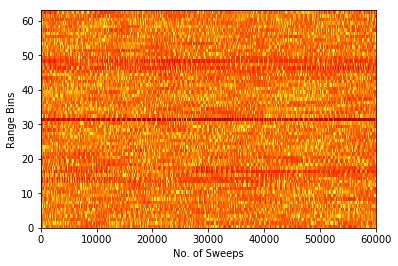

In [72]:
plt.xlabel("No. of Sweeps")
plt.ylabel("Range Bins")
plt.pcolormesh(20 * np.log10(abs(data_range_MTI)),cmap=plt.get_cmap('jet'))

In [224]:
bin_indl = 5
bin_indu = 25
MD = {}
MD["PRF"] = 1/sweep_time
MD["TimeWindowLength"] = 200
MD["OverlapFactor"] = 0.95
MD["OverlapLength"] = np.round(MD["TimeWindowLength"] * MD["OverlapFactor"])
MD["Pad_Factor"] = 4
MD["FFTPoints"] = MD["Pad_Factor"]*MD["TimeWindowLength"]
MD["DopplerBin"] = MD["PRF"]/MD["FFTPoints"]
MD["DopplerAxis"] = np.arange(-MD["PRF"]/2, MD["PRF"]/2-MD["DopplerBin"]+1, MD["DopplerBin"])               
MD["WholeDuration"] = data_range_MTI.shape[1]/MD["PRF"]

MD["NumSegments"] = np.floor(
    (data_range_MTI.shape[1]-MD["TimeWindowLength"])/
    (np.floor(MD["TimeWindowLength"]*(1-MD["OverlapFactor"])))
)

In [225]:
print(MD["FFTPoints"])

800


In [226]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(MD["TimeWindowLength"]),
                            noverlap=MD["OverlapLength"],
                            NFFT=MD["TimeWindowLength"], 
                            mode='complex',
                            pad_to=MD["FFTPoints"] )
#     print(s.shape)
    data_MTI_temp = np.fft.fftshift(s, 0)
#     print(data_MTI_temp.shape)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


In [227]:
def window_hamming(x):
    return np.hamming(x.shape[0])*x

In [237]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):
    print(data_range_MTI.shape)
    print(data_range_MTI[rbin, :].shape)
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=window_hamming,
                            noverlap=MD["OverlapLength"],
                            NFFT=MD["TimeWindowLength"], 
                            mode='complex',
                            pad_to=MD["FFTPoints"] )
    print(s.shape)
#     plt.imshow(im)
    data_MTI_temp = np.fft.fftshift(s, 0)
    print(data_MTI_temp.shape)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)
(63, 60000)
(60000,)
(401, 5981)
(401, 5981)


In [229]:
print(data_spec_MTI2.shape)

(401, 5981)


In [230]:
MD["TimeAxis"] = np.linspace(0,MD["WholeDuration"], data_spec_MTI2.shape[1])

In [231]:
data_spec_MTI2 = np.flipud(data_spec_MTI2/np.max(data_spec_MTI2[:]))

In [232]:
print(data_spec_MTI2.shape)
print(MD["TimeAxis"].shape, MD["DopplerAxis"].shape, (20*np.log10(abs(data_spec_MTI2))).shape)

(401, 5981)
(5981,) (800,) (401, 5981)


TypeError: Dimensions of C (401, 5981) are incompatible with X (5981) and/or Y (800); see help(pcolormesh)

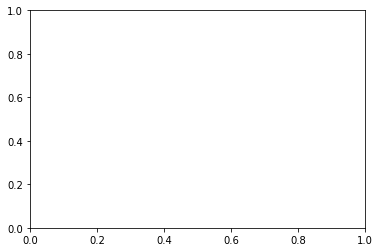

In [235]:
plt.pcolormesh(MD["TimeAxis"], MD["DopplerAxis"], 20*np.log10(abs(data_spec_MTI2)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(-150, 150)
plt.show()